## Exercise 1

### a) Explain the difference between Bagging, Random Forests, and Extra trees

**Bagging**
- Is a general technique for diversify the training data for each model in the ensemble
- Make bootstrapped datasets of the training data and train the models in parallel      

**Random Forest**
- Is an application of bagging using decision trees
- For each tree, at each decision node, pick a random subset of the features and only allow the algorithm to choose from those features
- Train trees on the bootstrapped training datasets and aggregate their predictions (majority class for classification and average for regression)

**Extra Trees**
- Each tree is trained on the entire training dataset
- Like in Random Forest, on each decision node only a subset of the features is taken into consideration for the split
- However, the value at which to split on numerical features is randomly chosen - because no algorithm is used to select this value and it’s just random it’s much faster than Random Forest

### b) Explain the difference between Bagging (and its associated methods) and Boosting methods

**Bagging**
- Diversify the training data for each model in the ensemble
- Make bootstrapped datasets of the training data and train the models in parallel
- Helps reduce overfitting and increases the robustness of the model     

**Boosting**
- Combine weak models into a stronger model
- The error of the previous model is used to improve the next model, the training is sequential unlike in bagging where it is parallel
- Helps reduce underfitting but doesn't help with overfitting

### c) Explain how the out-of-bag evaluation can be used with bagging
- For each individual model in the ensemble the training data points which were not sampled in the bootstrapped dataset this model is trained on can be used to evaluate it
- Since these samples were not used in the training of this model they are an unbiased estimate of the model's performance
- This way we have evaluation similar to that of a validation set without needing a designated validation set

## Exercise 2

We are working with the following small dataset and want to implement AdaBoost from scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings("ignore")

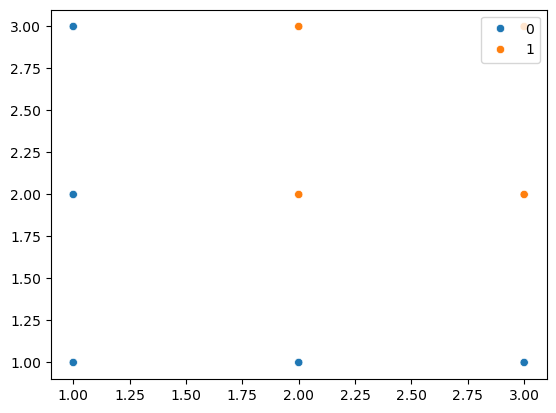

In [2]:
# Hard code the data set
X = np.array([[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]])
y = np.array([0, 0, 0, 0, 1, 1, 0, 1, 1])

# Visualize it
fig, ax = plt.subplots();
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax);

### Hyperparameters

In [10]:
steps = 3
alpha = 0.3

### Assign weights to all the data points & Get bootstrapped datasets

**- Start by assigning each training sample an equal weight**

In [59]:
n = X.shape[0]
# Initially all samples have equal weight
weights = np.full((n, 1), 1/n)
print("Initial sample weights:")
print(weights)
models = []
model_weights = []

#np.random.seed(0)
# get indices corresponding to bootstrapped dataset
print("Data sampled for the first bootstrapped dataset:")
bootstrapped_data = np.random.choice(n, (n, 1), replace=True, p=(weights[:,0]))
print(bootstrapped_data)

Initial sample weights:
[[0.11111111]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.11111111]]
Data sampled for the first bootstrapped dataset:
[[5]
 [7]
 [6]
 [6]
 [4]
 [8]
 [5]
 [3]
 [5]]


### Calculate amount of say of each stump and recalculate sample weights

- Calculate the total error for prediction with the stump you just created - the total error is calculated as the sum of the weights of all the misclassified training examples
$e = \sum_{i:h(x_i) \neq y_i} w_i$   
(In the example below it is normalized by dividing the total error by the total weight of all the samples)
- Calculate the amount to say of the stump
$a = \alpha \cdot ln(\frac{1-e}{e})$   
- Update the samples' weights
$w_{new} = w_{prev} \cdot e^{-a}$

In [60]:
def calculate_weights(y, yhat, weights, idx):
    
    idx_miss = idx[y != yhat]
    
    # normalized error
    r = weights[idx_miss].sum()/weights[idx].sum()
    print(f"error: {r}")

    # amount to say of model (this implementation also uses learning rate alpha as a hyperparameter)
    importance = alpha * np.log((1 - r)/(r + 0.0000001))
    print(f"importance: {importance}")

    new_weights = np.copy(weights)
    
    # updated sample weights
    new_weights[np.unique(idx_miss)] = new_weights[np.unique(idx_miss)] * math.exp(importance)
    print(f"new weights: {new_weights}")

    total = new_weights.sum()
    new_weights = (new_weights/total).reshape(-1,1)

    return importance, new_weights

### Training loop

- **Train each decision stump on a bootstrapped dataset, then calculate its amount of say and recalculate the sample weights**

In [61]:
for i in range(steps):

    print(f"---Stump no. {i+1}---")
    idx = bootstrapped_data[:, i]
    
    # train a decision stump on the current bootstrapped training dataset
    model = DecisionTreeClassifier(random_state=42, max_depth=1)
    model = model.fit(X[idx], y[idx])
    models.append(model)
    
    preds = model.predict(X[idx])
    print(f"model predictions: {preds}")
    print(f"true values: {y[idx]}")
   
    # calculate the model's amount of say and the new sample weights based on the model's predictions
    importance, new_weights = calculate_weights(y[idx], preds, weights[:,0], idx)
    
    #print(new_weights)
    model_weights.append(importance)
    weights = np.hstack((weights, new_weights))
    #print(weights)
    
    if i < (steps - 1):
        
        # get a new bootstrapped dataset for training the next model, prioritizing the missclassified samples
        new_samples_idx = np.random.choice(n, (n, 1), replace=True, p=weights[:,0])
        bootstrapped_data = np.hstack((bootstrapped_data, new_samples_idx))


---Stump no. 1---
model predictions: [1 1 0 0 1 1 1 0 1]
true values: [1 1 0 0 1 1 1 0 1]
error: 0.0
importance: 4.835428695287496
new weights: [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
---Stump no. 2---
model predictions: [0 0 1 0 1 1 0 0 1]
true values: [0 0 1 0 1 0 0 0 1]
error: 0.1111111111111111
importance: 0.6238321925040723
new weights: [0.11111111 0.11111111 0.11111111 0.20734061 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
---Stump no. 3---
model predictions: [1 1 1 1 0 1 0 0 1]
true values: [1 1 1 1 0 1 0 0 1]
error: 0.0
importance: 4.835428695287496
new weights: [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]


In [62]:
print(model_weights)

[4.835428695287496, 0.6238321925040723, 4.835428695287496]


### Prediction

- **Predict class probabilities using all the stumps in the ensemble, add them up taking into account the amount of say of each model, and normalize to get back probabilities**

- **Then predict the class with the highest resulting probability**

In [63]:
def predict(X):

    result = 0

    for i in range(steps):

        yhat = model_weights[i] * models[i].predict_proba(X)

        result += yhat


    probs = result/sum(model_weights)

    preds = np.argmax(probs, axis=1)
    
    return preds

### Calculate training error

In [64]:
preds_train = predict(X)
preds_train

array([0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [65]:
y

array([0, 0, 0, 0, 1, 1, 0, 1, 1])

In [66]:
error = 1 - accuracy_score(y, preds_train)
print(f"Training error: {error}")

Training error: 0.11111111111111116


### Visualize decision boundary

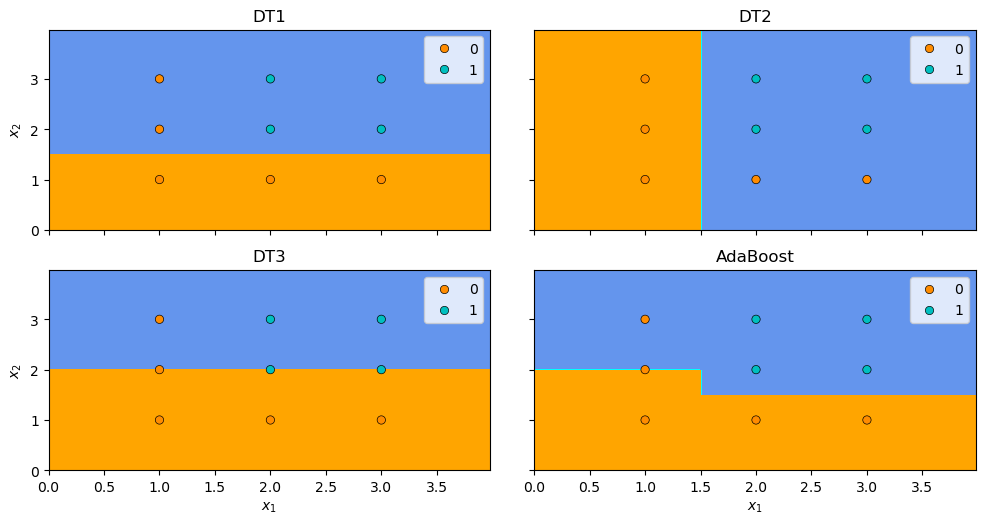

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=.2);

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define classifiers
clfs = [models[:2], [models[2], None]]

# Define titles
titles = [["DT1", "DT2"], ["DT3", "AdaBoost"]]

# Mesh step
h = 0.02

for i in range(2):
    for j in range(2):
        
        # Get ax
        ax = axs[i, j]

        # Plot the decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        if clfs[i][j] != None:
            Z = clfs[i][j].predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
        ax.set_xlim(xx.min(), xx.max());
        ax.set_ylim(yy.min(), yy.max());
        ax.set_title(titles[i][j]);
        ax.set_xlabel("$x_1$");
        ax.set_ylabel("$x_2$");

## Exercise 3   
### In your own words, explain the differece between AdaBoost and Gradient Boosting

**AdaBoost**
- Uses a bunch of weak learners which are usually decision stumps (decision trees with only one split)
- In AdaBoost, each stump has a different amount to say (weight) in the final prediction for each sample

**Gradient Boosting**
- Decision trees with depth 3 are usually used as weak learners
- Start with an initial prediction (for regression usually the average of the target value) and  alculate the residuals if you make that start prediction for every sample
- Make a new decision tree with those residuals as the target values (y) and repeat these steps until you reach the number of trees you want

## Exercise 4

In [28]:
path_train = "Exercise17/Ex1-training.csv"
path_test = "Exercise17/Ex1-test.csv"

train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [29]:
X = test[["x1", "x2"]]
y = test["y"]
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [32]:
X_train = train[["x1", "x2"]]
y_train = train["y"]

### Use GradientBoostingClassifier from sklearn to build an ensemble of trees with max_depth=3

In [33]:
clf = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, max_depth=3, random_state=42).fit(X_train, y_train)

preds_train = clf.predict(X_train)
preds_val = clf.predict(X_val)

acc_train = accuracy_score(y_train, preds_train)
acc_val = accuracy_score(y_val, preds_val)
f1_train = f1_score(y_train, preds_train, average="macro")
f1_val = f1_score(y_val, preds_val, average="macro")
cm_train = confusion_matrix(y_train, preds_train)
cm_val = confusion_matrix(y_val, preds_val)

print(f"Accuracy train: {acc_train}")
print(f"F1 train: {f1_train}")
print("Confusion matrix train: ")
print(cm_train)

print(f"Accuracy val: {acc_val}")
print(f"F1 val: {f1_val}")
print("Confusion matrix val: ")
print(cm_val)

Accuracy train: 0.9111111111111111
F1 train: 0.9097085430969506
Confusion matrix train: 
[[292   8   0]
 [ 39 242  19]
 [  0  14 286]]
Accuracy val: 0.8706666666666667
F1 val: 0.8711432809914171
Confusion matrix val: 
[[899  70   0]
 [156 817  57]
 [  3 102 896]]


### Visualize the decision boundaries (reused code from decision tree exercise)

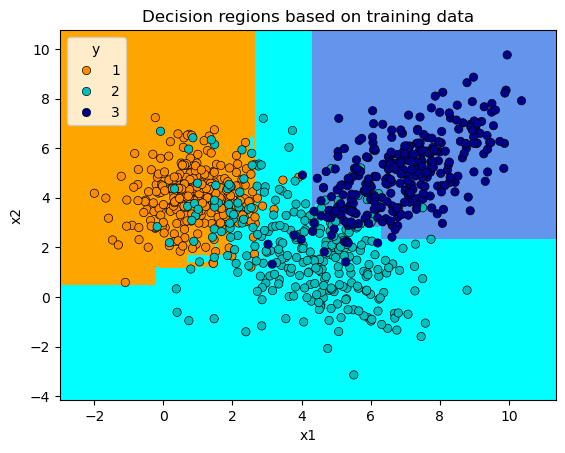

In [42]:
# Define plot
fig, ax = plt.subplots()

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Mesh step
h = 0.02

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=train, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"Decision regions based on training data");

### Try different values for n_estimators and learning_rate

In [43]:
n_ests = [10, 25, 50, 75, 100]

lrs = [0.001, 0.01, 0.03, 0.1, 1]

for n_est in n_ests:
    for lr in lrs:
        
        print(f"----for n_estimators={n_est} and learning_rate={lr}----")
        curr_clf = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr, 
                                              max_depth=3, random_state=42).fit(X_train, y_train)

        preds_train = curr_clf.predict(X_train)
        preds_val = curr_clf.predict(X_val)

        acc_train = accuracy_score(y_train, preds_train)
        acc_val = accuracy_score(y_val, preds_val)
        f1_train = f1_score(y_train, preds_train, average="macro")
        f1_val = f1_score(y_val, preds_val, average="macro")
        cm_train = confusion_matrix(y_train, preds_train)
        cm_val = confusion_matrix(y_val, preds_val)

        print(f"Accuracy train: {acc_train}")
        print(f"F1 train: {f1_train}")
        print("Confusion matrix train: ")
        print(cm_train)

        print(f"Accuracy val: {acc_val}")
        print(f"F1 val: {f1_val}")
        print("Confusion matrix val: ")
        print(cm_val)

----for n_estimators=10 and learning_rate=0.001----
Accuracy train: 0.8933333333333333
F1 train: 0.8911956321043225
Confusion matrix train: 
[[289  11   0]
 [ 42 231  27]
 [  0  16 284]]
Accuracy val: 0.867
F1 val: 0.8672792098475552
Confusion matrix val: 
[[896  73   0]
 [158 806  66]
 [  3  99 899]]
----for n_estimators=10 and learning_rate=0.01----
Accuracy train: 0.8933333333333333
F1 train: 0.8911956321043225
Confusion matrix train: 
[[289  11   0]
 [ 42 231  27]
 [  0  16 284]]
Accuracy val: 0.867
F1 val: 0.8672792098475552
Confusion matrix val: 
[[896  73   0]
 [158 806  66]
 [  3  99 899]]
----for n_estimators=10 and learning_rate=0.03----
Accuracy train: 0.8944444444444445
F1 train: 0.892262844648828
Confusion matrix train: 
[[290  10   0]
 [ 42 231  27]
 [  0  16 284]]
Accuracy val: 0.868
F1 val: 0.8682293807723461
Confusion matrix val: 
[[899  70   0]
 [158 806  66]
 [  3  99 899]]
----for n_estimators=10 and learning_rate=0.1----
Accuracy train: 0.8944444444444445
F1 train:

## Exercise 5 

- Load the MNIST data and split it into a training set, a validation set.

- Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and some other classifier of your choice.

- Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

- Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?


In [72]:
from sklearn.datasets import load_digits
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [73]:
X, y = load_digits(return_X_y=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_train.shape

(806, 64)

In [74]:
# Define models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
extree = ExtraTreesClassifier(n_estimators=100, random_state=42)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

clfs = [rf, extree, lda, qda]
names = ['RF', 'Extree', 'LDA', 'QDA']

In [75]:
# Individual performance

f1_scores = []
for i, clf in enumerate(clfs):

    clf.fit(X_train, y_train)
    yhat = clf.predict(X_val)
    f1 = f1_score(y_val, yhat, average='macro')
    f1_scores.append(round(f1,4))

individual_df = pd.DataFrame([f1_scores], columns= names)
individual_df

,RF,Extree,LDA,QDA
0,0.9725,0.9769,0.9478,0.8312


In [76]:
# Ensemble with hard voting

def hard_vote(clfs, X):

    # Get predictions
    yhat = None
    for clf in clfs:
        # Predict and save
        pred = clf.predict(X).reshape(-1,1)
        if yhat is None:
            yhat = pred
        else: 
            yhat = np.hstack((yhat, pred))

    # Majority vote
    hard_predictions = np.zeros(yhat.shape[0], dtype=int)

    for i, row in enumerate(yhat):

        unique_values, counts = np.unique(row, return_counts=True)
        max_count_index = np.argmax(counts)
        hard_predictions[i] = unique_values[max_count_index]

    return hard_predictions

pred_train_hard = hard_vote(clfs, X_train)
pred_train_hard.shape

(806,)

In [77]:
# Ensemble with soft voting 

def soft_vote(clfs, X):
    probs = None
    for clf in clfs: 
        prob = clf.predict_proba(X)
        if probs is None:
            probs = prob
        else:
            probs += prob

    avg_prob = probs/ len(clfs)

    soft_predictions = np.argmax(avg_prob, axis=1)
    return soft_predictions

pred_train_soft = soft_vote(clfs, X_train)
pred_train_soft.shape


(806,)

In [78]:
# Choose best with validation set

# Predict on val set
pred_val_hard = hard_vote(clfs, X_val)
pred_val_soft = soft_vote(clfs, X_val)

# Compute f1score 
f1_hard = f1_score(y_val, pred_val_hard, average="macro")
f1_soft = f1_score(y_val, pred_val_soft, average = "macro")

print('Performance on validation set:')
print('Macro f1 score - Hard vote: ', round(f1_hard,4))
print('Macro f1 score - Soft vote: ', round(f1_soft,4))

Performance on validation set:
Macro f1 score - Hard vote:  0.9796
Macro f1 score - Soft vote:  0.9783


In [79]:
individual_df

,RF,Extree,LDA,QDA
0,0.9725,0.9769,0.9478,0.8312


In [80]:
# Evaluate on test 

pred_test = hard_vote(clfs, X_test)
f1_test = f1_score(y_test, pred_test, average="macro")
print('Test F1 score: ', round(f1_test,4))

Test F1 score:  0.9745


## Exercise 6

- Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [82]:
def predictions(clfs, X):

    yhat = None
    for clf in clfs:
        # Predict and save
        pred = clf.predict(X).reshape(-1,1)
        if yhat is None:
            yhat = pred
        else: 
            yhat = np.hstack((yhat, pred))
    return yhat

pred_val = predictions(clfs, X_val)
pred_val.shape

(397, 4)

In [83]:
# Define blender model
blender = LogisticRegression()

# Fit blender with individual predictions
blender.fit(pred_val, y_val)

LogisticRegression()

In [84]:
# Evaluate Stacking ensemble on test set 

# Predict with individual clfs
pred_test = predictions(clfs,X_test)

# Use those as new features to predict with blender 
pred_test_stacking = blender.predict(pred_test)

# Evaluate
f1_stack = f1_score(pred_test_stacking, y_test, average="macro")
print('Performance of Stacking ensemble model on test set: ', round(f1_stack, 4))

Performance of Stacking ensemble model on test set:  0.9373
